# Adaptive Finite Element [(Notebook)][1]

[1]: _downloads/laplace-adaptive.ipynb
We study the classic _re-entrant corner_ problem:
\begin{align*}
  -\Delta u &= f && \text{in } \Omega \\
          u &= g && \text{on } \partial\Omega
\end{align*}
where the domain is given using polar coordinates
\begin{gather}
  \Omega = \{ (r,\varphi)\colon r\in(0,1), \varphi\in(0,\Phi) \}~.
\end{gather}
For $g$ we take the trace of the function $u$, given by
\begin{gather}
  u(r,\varphi) = r^{\frac{\pi}{\Phi}} \sin\big(\frac{\pi}{\Phi} \varphi \big)
\end{gather}

We first define the domain and set up the grid and space

In [1]:
try:
    %matplotlib inline # can also use notebook or nbagg
except:
    pass
import math
import numpy
import matplotlib.pyplot as pyplot
import dune.create as create
from dune.fem.view import adaptiveLeafGridView
from dune.fem.plotting import plotPointData as plot
import dune.grid as grid
import dune.fem as fem

# set the angle for the corner (0<angle<=360)
cornerAngle = 320.

# use a second order space
order = 2

# define the grid for this domain (vertices are the origin and 4 equally spaced points on the
# unit sphere starting with (1,0) and ending at # (cos(cornerAngle), sin(cornerAngle))
vertices = numpy.zeros((8,2))
vertices[0] = [0,0]
for i in range(0,7):
    vertices[i+1] = [math.cos(cornerAngle/6*math.pi/180*i),
                     math.sin(cornerAngle/6*math.pi/180*i)]
triangles = numpy.array([[2,1,0], [0,3,2], [4,3,0], [0,5,4], [6,5,0], [0,7,6]])
domain = {"vertices": vertices, "simplices": triangles}
view = create.view("adaptive", "ALUConform", domain, dimgrid=2)
view.hierarchicalGrid.globalRefine(2)
spc  = create.space( "lagrange", view, dimrange=1, order=order )

2018-06-10 00:25:04,076 - dune.common - INFO - MPI initialized successfully
2018-06-10 00:25:04,086 - dune.common.module - INFO - Using existing dune-py module in /home/dedner/Envs/dune3/.cache/dune-py
2018-06-10 00:25:04,087 - dune.generator.builder - INFO - using pre configured dune-py module
2018-06-10 00:25:04,232 - dune.create - INFO - Importing create registries from [ dune.femnv dune.functions dune.grid dune.fem dune.alugrid dune.vem ]
2018-06-10 00:25:04,237 - dune.generator.builder - INFO - Loading HierarchicalGrid
2018-06-10 00:25:04,366 - dune.generator.builder - INFO - Loading ReferenceElements
2018-06-10 00:25:04,473 - dune.generator.builder - INFO - Loading ReferenceElements
2018-06-10 00:25:04,584 - dune.generator.builder - INFO - Loading ReferenceElements
2018-06-10 00:25:04,693 - dune.generator.builder - INFO - Loading GridView
2018-06-10 00:25:04,825 - dune.generator.builder - INFO - Loading Space


Next define the model together with the exact solution.

In [2]:
from ufl import *
from dune.ufl import Space, DirichletBC
uflSpace = Space(view, 1)
u = TrialFunction(uflSpace)
v = TestFunction(uflSpace)
x = SpatialCoordinate(uflSpace.cell())

# exact solution for this angle
Phi = cornerAngle / 180 * math.pi
phi = atan_2(x[1], x[0]) + conditional(x[1] < 0, 2*math.pi, 0)
exact = as_vector([inner(x,x)**(math.pi/2/Phi) * sin(math.pi/Phi * phi)])
a = inner(grad(u), grad(v)) * dx

# set up the scheme
laplace = create.scheme("h1", spc, [a==0, DirichletBC(uflSpace,exact,1)])
uh = spc.interpolate(lambda x: [0], name="solution")

2018-06-10 00:25:05,026 - dune.generator.builder - INFO - Loading ellipticModel
2018-06-10 00:25:05,161 - dune.generator.builder - INFO - Loading Scheme
2018-06-10 00:25:05,296 - dune.generator.builder - INFO - Loading DiscreteFunction
2018-06-10 00:25:05,427 - dune.generator.builder - INFO - Loading gridfunctions


Theory tells us that
\begin{align*}
  \int_\Omega \nabla(u-u_h) \leq \sum_K \eta_K
\end{align*}
where on each element $K$ of the grid the local estimator is given by
\begin{align*}
  \eta_K = h_K^2 \int_K |\triangle u_h|^2 +
    \frac{1}{2}\sum_{S\subset \partial K} h_S \int_S [\nabla u_h]^2
\end{align*}
Here $[\cdot]$ is the jump in normal direction over the edges of the grid.

We compute the elementwise indicator by defining a bilinear form
\begin{align*}
  \eta(u,v) = h_K^2 \int_K |\triangle u_h|^2 v +
    \sum_{S\subset \partial K} h_S \int_S [\nabla u_h]^2 \{v\}
\end{align*}
where $\{\cdot\}$ is the average over the cell edges. This bilinear form can be easily written in UFL and by using it to define a discrete operator $L$ from the second order Lagrange space into a space containing piecewise constant functions 
we have $L[u_h]|_{K} = \eta_K$.

In [3]:
# energy error
h1error = inner(grad(uh - exact), grad(uh - exact))

# residual estimator
fvspc = create.space("finitevolume", view, dimrange=1, storage="istl")
estimate = fvspc.interpolate([0], name="estimate")

hT = MaxCellEdgeLength(uflSpace.cell())
he = MaxFacetEdgeLength(uflSpace.cell())('+')
n = FacetNormal(uflSpace.cell())
estimator_ufl = hT**2 * (div(grad(u[0])))**2 * v[0] * dx \
                + he * inner(jump(grad(u[0])), n('+'))**2 * avg(v[0]) * dS
estimator_model = create.model("integrands", view, estimator_ufl == 0)
estimator = create.operator("galerkin", estimator_model, spc, fvspc)

# marking strategy (equidistribution)
tolerance = 0.1
gridSize = view.size(0)
def mark(element):
    estLocal = estimate(element, element.geometry.referenceElement.center)
    return grid.Marker.refine if estLocal[0] > tolerance / gridSize else grid.Marker.keep

2018-06-10 00:25:05,589 - dune.generator.builder - INFO - Loading Space
2018-06-10 00:25:05,716 - dune.generator.builder - INFO - Loading DiscreteFunction
2018-06-10 00:25:05,858 - dune.generator.builder - INFO - Loading integrands
2018-06-10 00:25:05,990 - dune.generator.builder - INFO - Loading Operator


Let us create a function `matplot` for plotting the figures side by side in matplotlib.

2018-06-10 00:25:06,503 - dune.generator.builder - INFO - Loading localFunction
2018-06-10 00:25:06,629 - dune.generator.builder - INFO - Loading GridAdaptation


0 : size= 24 estimate= 1.2432410911596623 error= 0.16712344009166377
1 : size= 42 estimate= 0.978048205049365 error= 0.14720112557589932
2 : size= 60 estimate= 0.5688673662222816 error= 0.11275722709417108


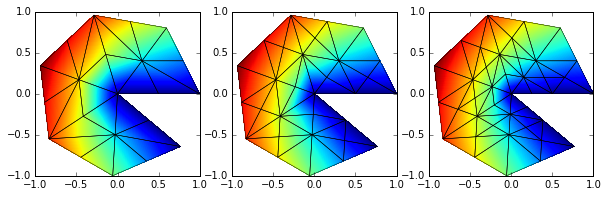

3 : size= 78 estimate= 0.45351205486043145 error= 0.09976842536010311
4 : size= 96 estimate= 0.2693940487892911 error= 0.07693183608657275
5 : size= 114 estimate= 0.21720076735515306 error= 0.06830967506879779


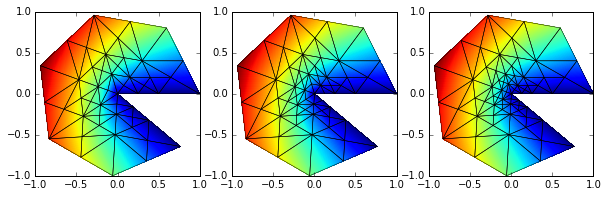

6 : size= 132 estimate= 0.1332272842546952 error= 0.05316116865447578
7 : size= 146 estimate= 0.11095421205211038 error= 0.04763785145920941
8 : size= 168 estimate= 0.07093392719962319 error= 0.03753956416619798


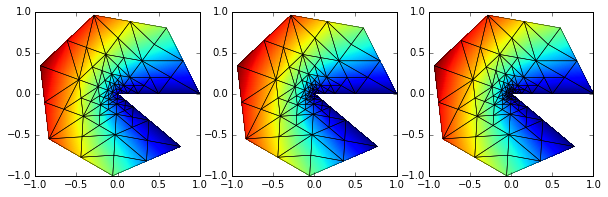

In [4]:
# adaptive loop (solve, mark, estimate)
fig = pyplot.figure(figsize=(10,10))
count = 0
while count < 20:
    laplace.solve(target=uh)
    if count%3 == 0:
        pyplot.show()
        pyplot.close('all')
        fig = pyplot.figure(figsize=(10,10))
    plot(uh,figure=(fig,131+count%3), colorbar=False)
    # compute the actual error and the estimator
    error = math.sqrt(fem.function.integrate(view, h1error, 5)[0])
    estimator(uh, estimate)
    eta = sum(estimate.dofVector)
    print(count, ": size=", gridSize, "estimate=", eta, "error=", error)
    if eta < tolerance:
        break
    if tolerance == 0.:
        view.hierarchicalGrid.globalRefine(2)
        uh.interpolate([0])  # initial guess needed
    else:
        marked = view.hierarchicalGrid.mark(mark)
        fem.adapt(view.hierarchicalGrid, [uh])
        fem.loadBalance(view.hierarchicalGrid, [uh])
    gridSize = view.size(0)
    laplace.solve( target=uh )
    count += 1
pyplot.show()
pyplot.close('all')

Let's have a look at the center of the domain:

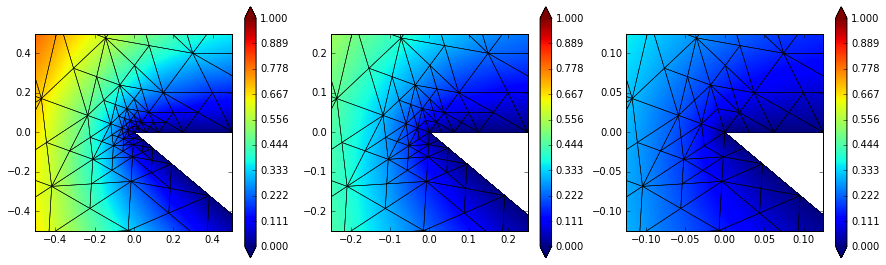

In [9]:
fig = pyplot.figure(figsize=(15,15))
plot(uh, figure=(fig,131+0), xlim=(-0.5,0.5), ylim=(-0.5,0.5),colorbar={"shrink":0.3})
plot(uh, figure=(fig,131+1), xlim=(-0.25,0.25), ylim=(-0.25,0.25),colorbar={"shrink":0.3})
plot(uh, figure=(fig,131+2), xlim=(-0.125,0.125), ylim=(-0.125,0.125),colorbar={"shrink":0.3})
pyplot.show()
pyplot.close('all')

Finally, let us have a look at the grid levels:

In [ ]:
from dune.fem.function import levelFunction
plot(levelFunction(view), xlim=(-0.2,1), ylim=(-0.2,1))